<a href="https://colab.research.google.com/github/uprestel/AutoNeRF/blob/master/nerf_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NeRF Implementation
In this Notebook we do the following:
* load a small training set $\mathcal{T}$
* train NeRF on this training set
* generate a new training net $\hat{\mathcal{T}}$ using NeRF 


In [1]:
# Import all the good stuff :)

!git clone https://github.com/uprestel/AutoNeRF.git
import AutoNeRF.models.nerf as nerf
import AutoNeRF.data.data
from AutoNeRF.data.data import AutoNeRF_Dataset
from AutoNeRF.util.transforms import random_rotation, look_at_rotation

import torchvision
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import os


from google.colab import drive
drive.mount('/gdrive', force_remount=True)


Cloning into 'AutoNeRF'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 410 (delta 16), reused 0 (delta 0), pack-reused 370
Receiving objects: 100% (410/410), 36.51 MiB | 32.74 MiB/s, done.
Resolving deltas: 100% (212/212), done.
Mounted at /gdrive


## Load small dataset $\mathcal{T}$
We load the small dataset we train NeRF on, then we display a chosen test- image. Note that this test-image is not used during training.
Our dataset has the following properties
* our scenes can be contained in a ball $B_r(0)$ with $r=2$
* we only sample from our rays within this ball


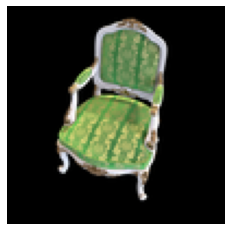

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = AutoNeRF_Dataset("/gdrive/My Drive/chair.npz")

# For all our scenes our object is enclosed in a ball at the origin with radius 2
SCENE_RADIUS = 2

def show(image, permutation=(0,1,2)):
    grid_img = torchvision.utils.make_grid(image, nrow=5)
    plt.imshow(grid_img.permute(permutation))
    plt.axis('off')
    plt.show()


def get_thresholds(r):
    diff = r - SCENE_RADIUS
    tn = diff
    tf = diff + 2*SCENE_RADIUS

    return tn, tf



images = torch.from_numpy(dataset.images).to(device)
focal_length = torch.from_numpy(dataset.focal_length).to(device)
poses = torch.from_numpy(dataset.poses).to(device)

height, width = images.shape[1:3]



testimg = images[99, ..., :3]
testpose = poses[99]


translation = poses[:, :3,3]
center = torch.zeros(3).to(device)
diff = center - translation

n = torch.norm(diff, p=2, dim=1)
radius = torch.mean(n)

show(images[99].cpu())

#### Display the first 10 images form the dataset

In [ ]:
for i in range(0, 10):
    show(images[i].cpu())

## Train NeRF


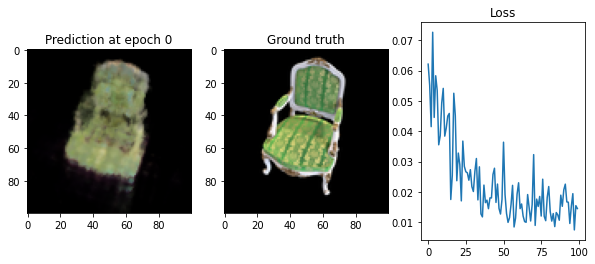

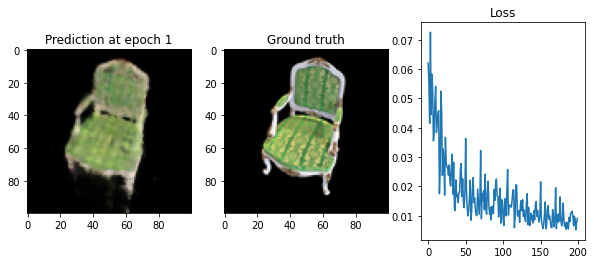

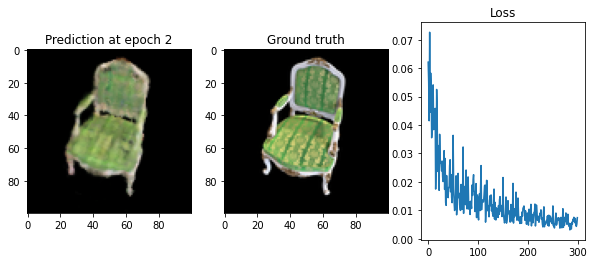

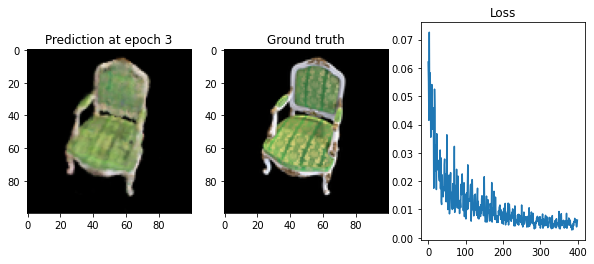

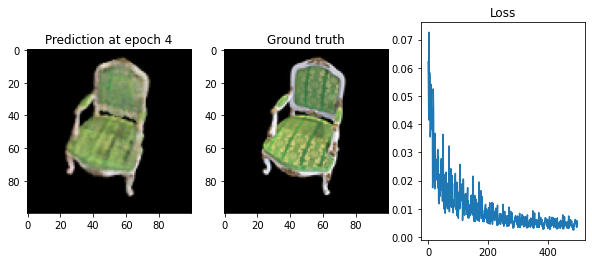

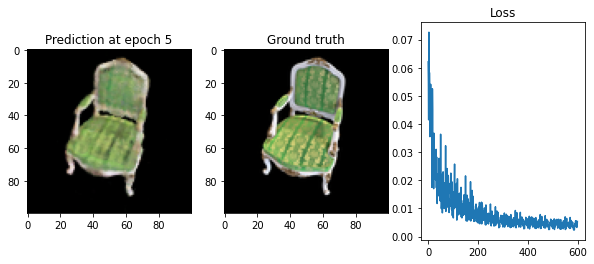

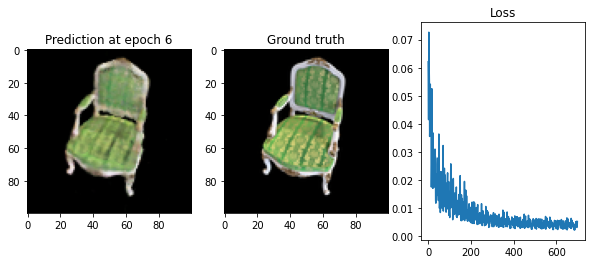

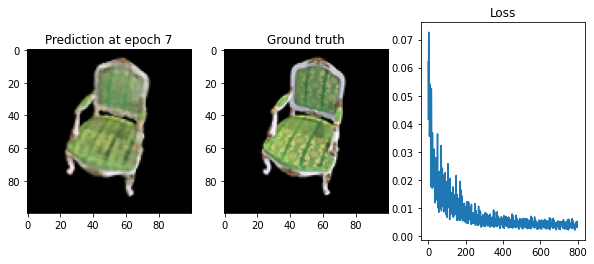

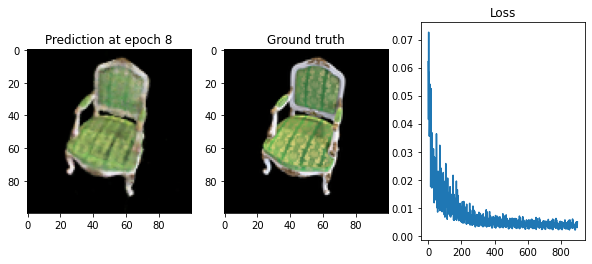

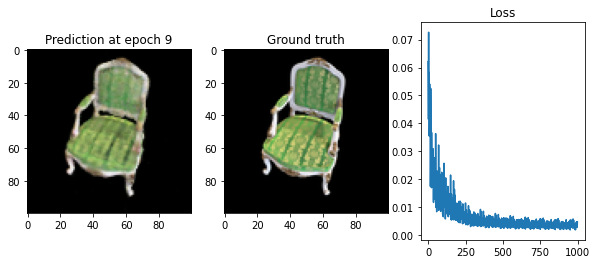

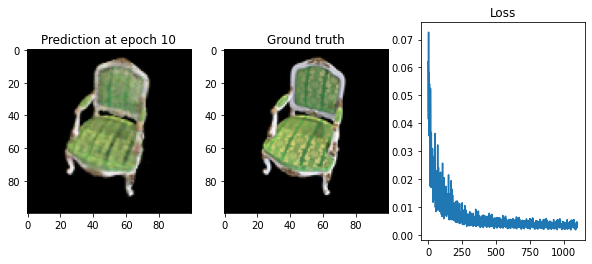

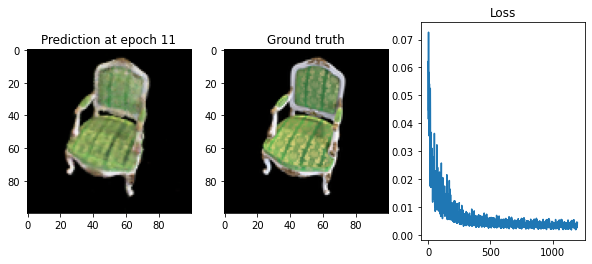

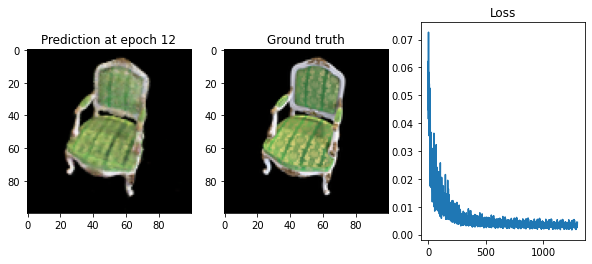

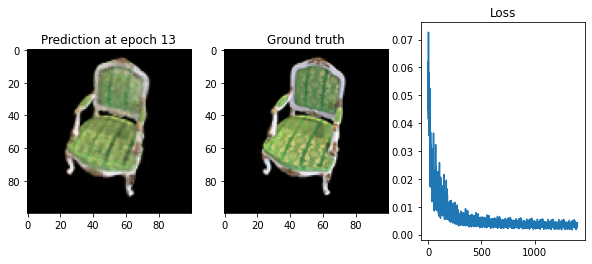

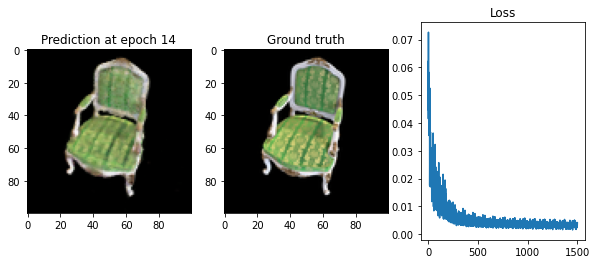

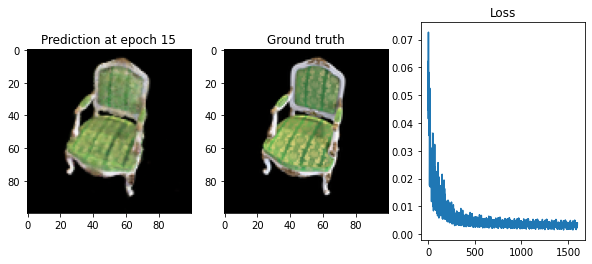

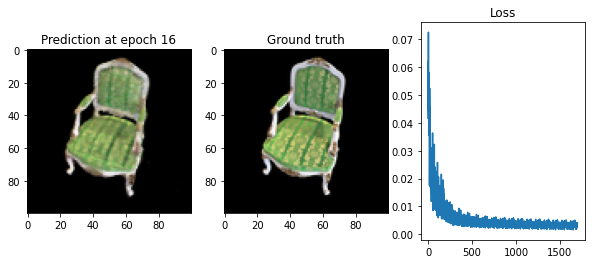

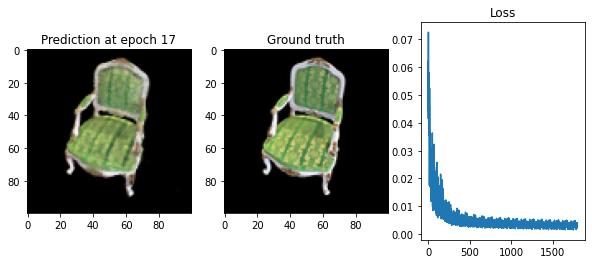

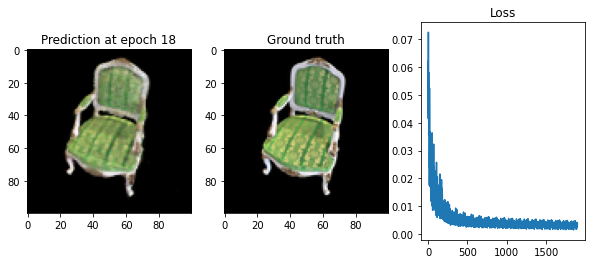

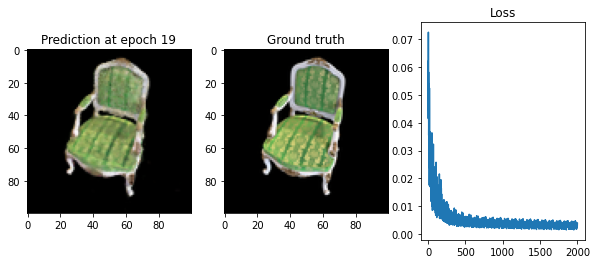

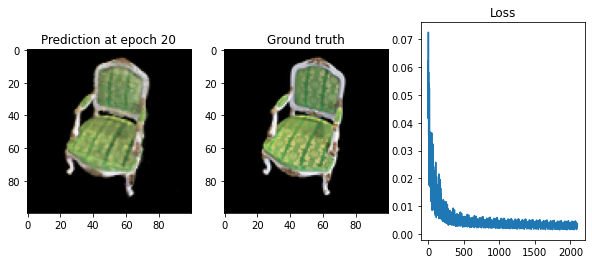

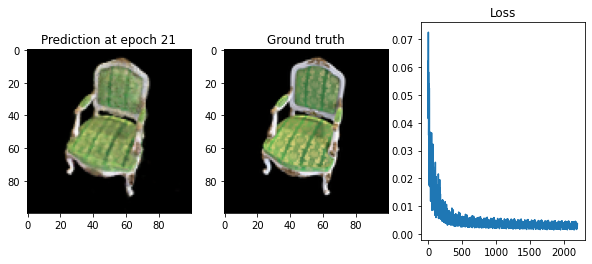

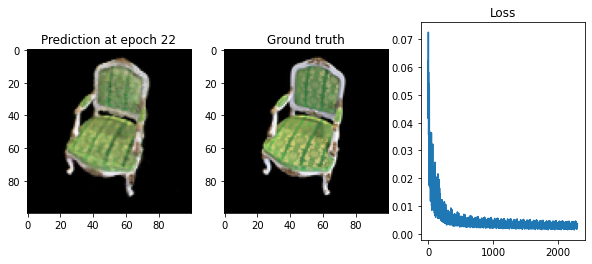

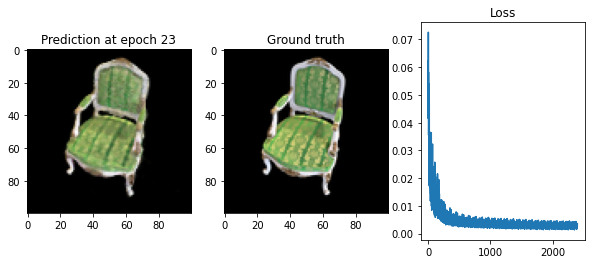

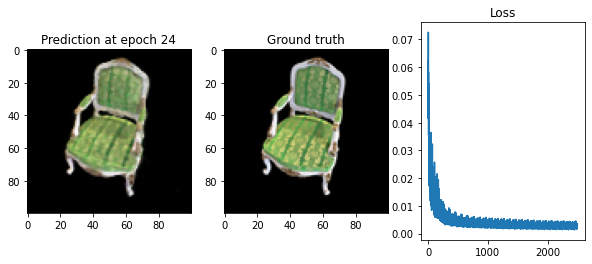

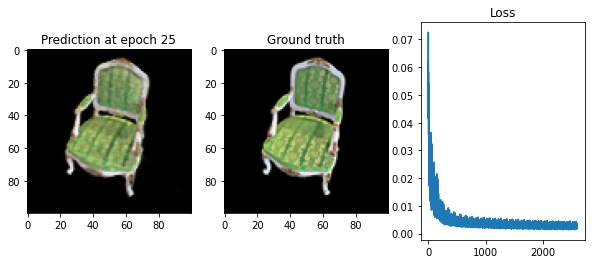

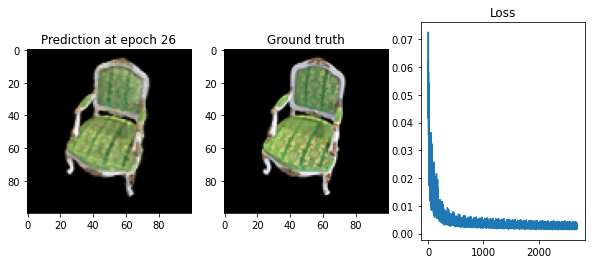

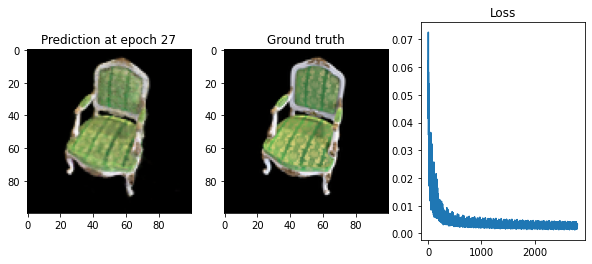

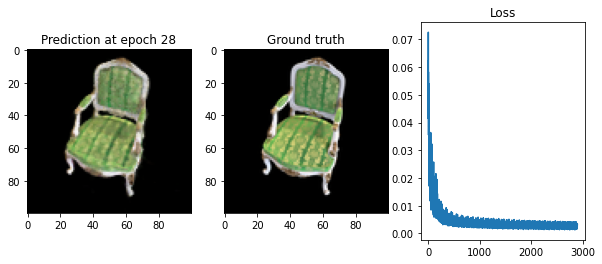

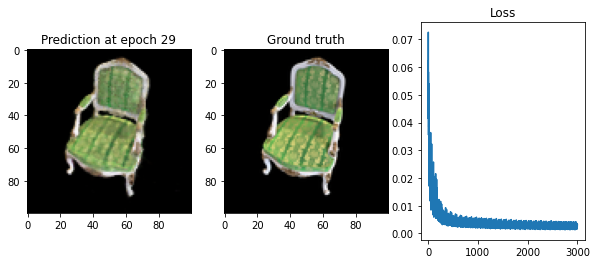

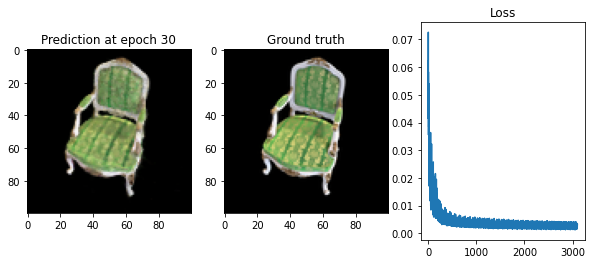

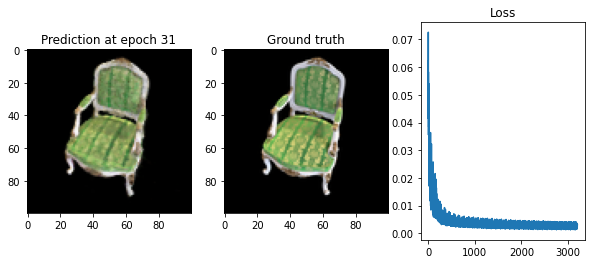

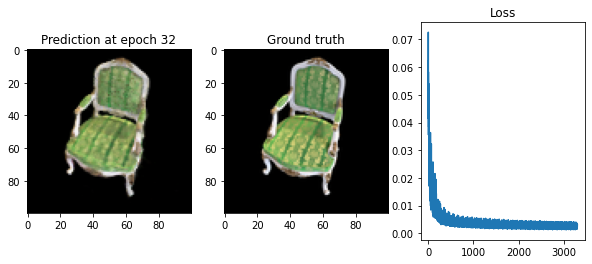

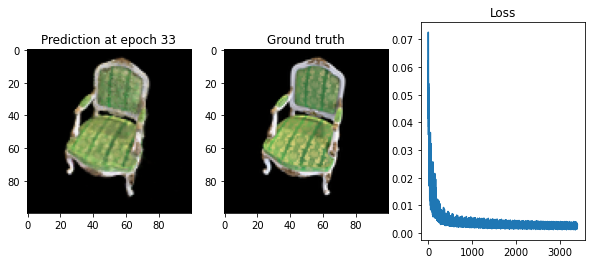

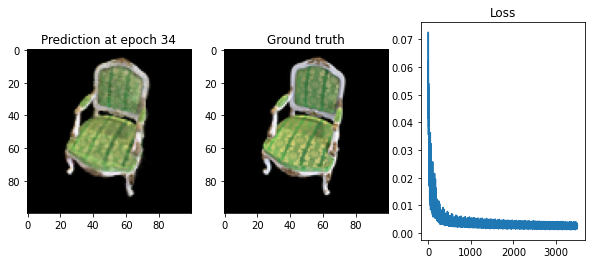

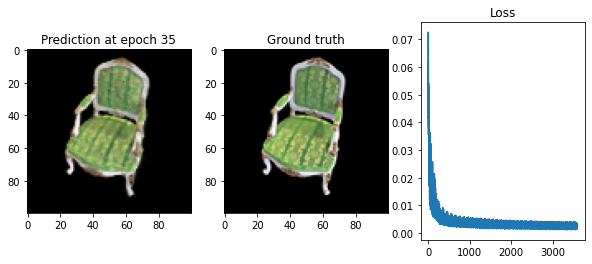

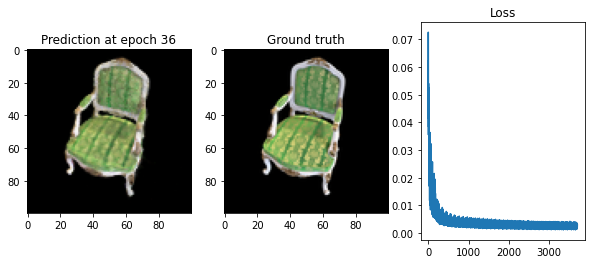

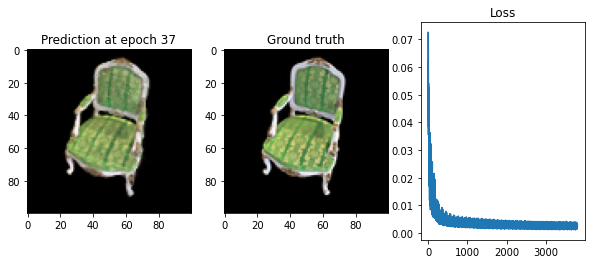

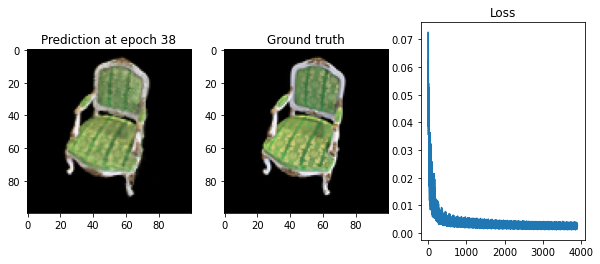

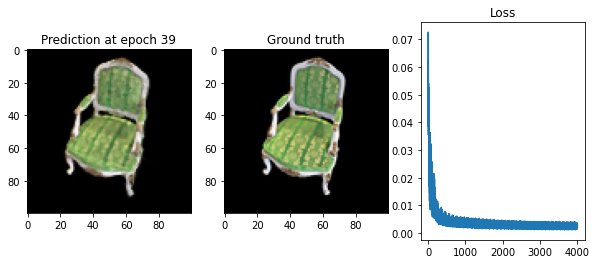

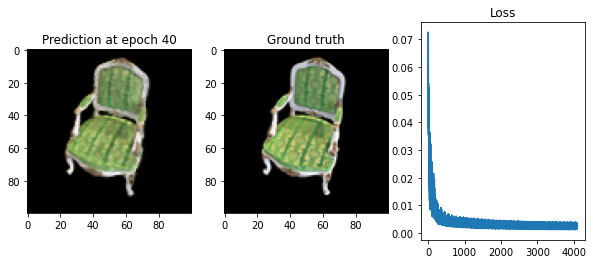

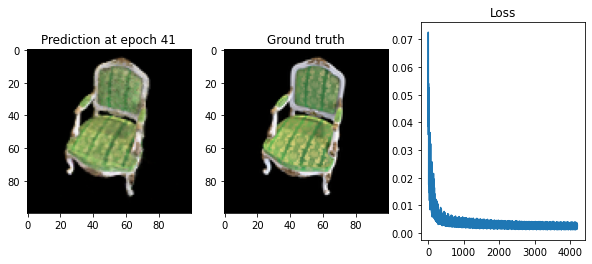

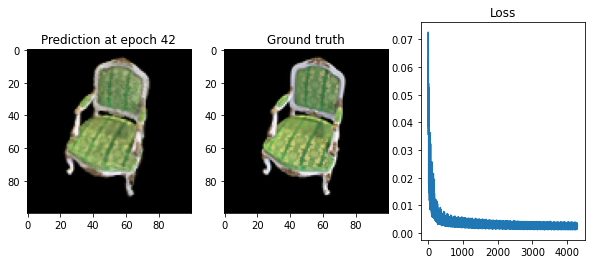

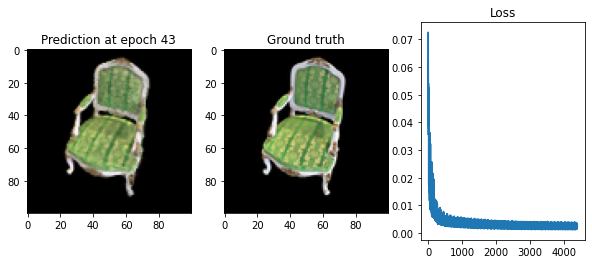

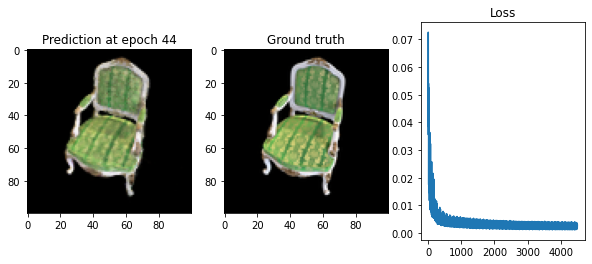

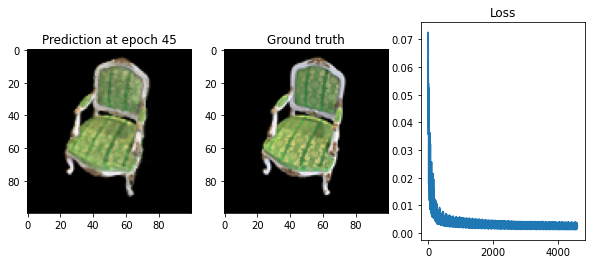

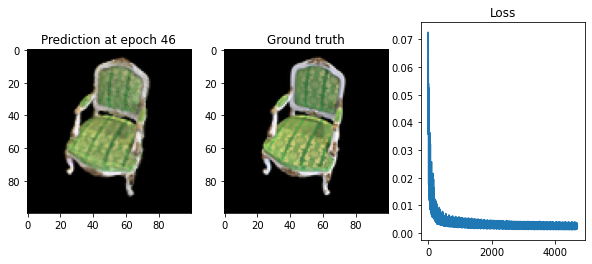

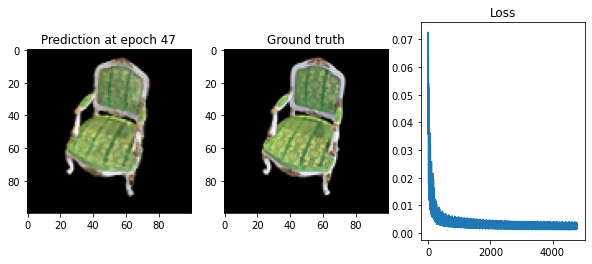

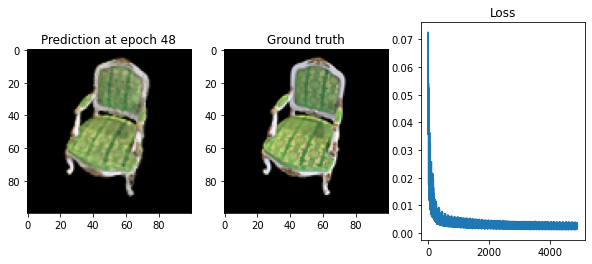

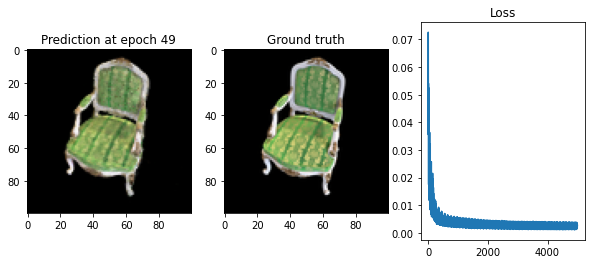

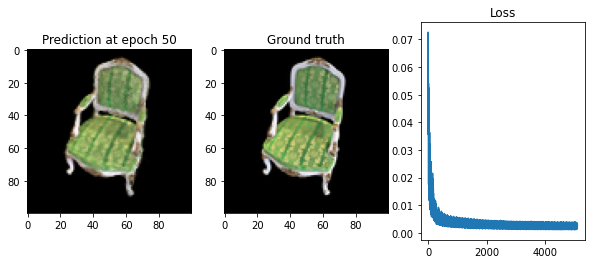

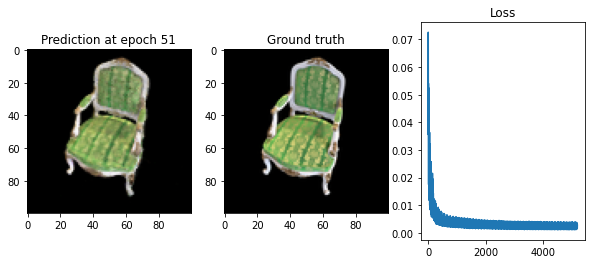

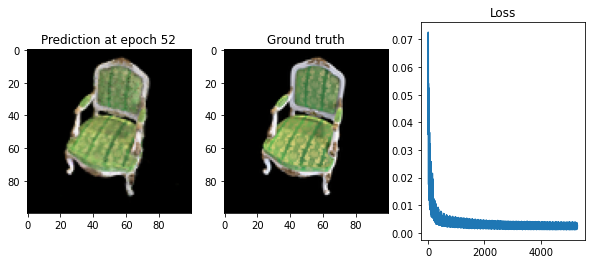

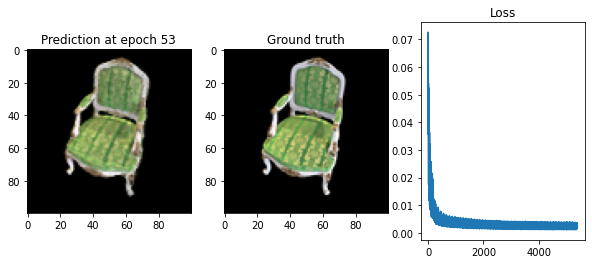

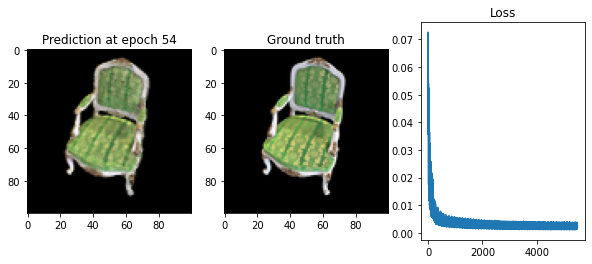

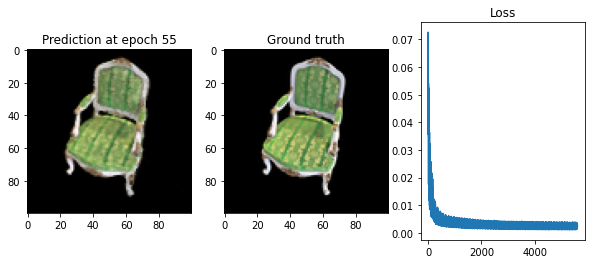

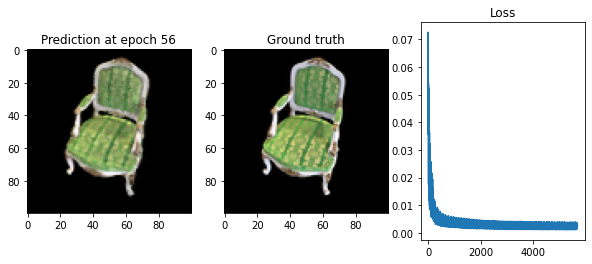

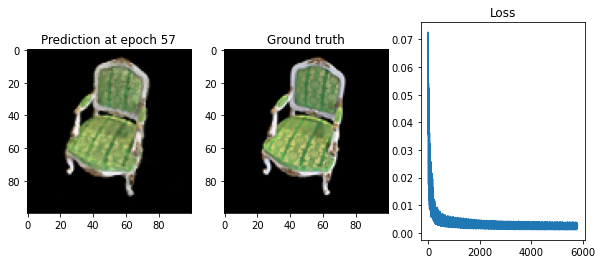

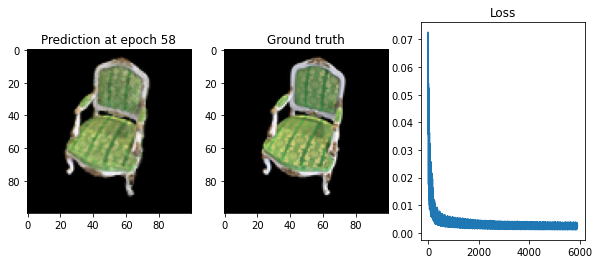

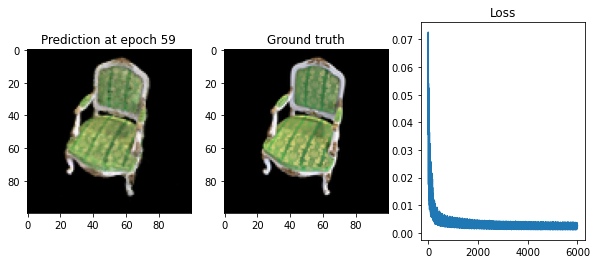

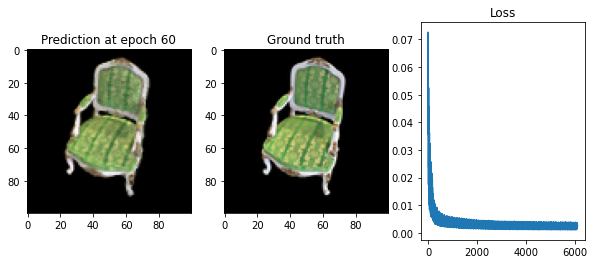

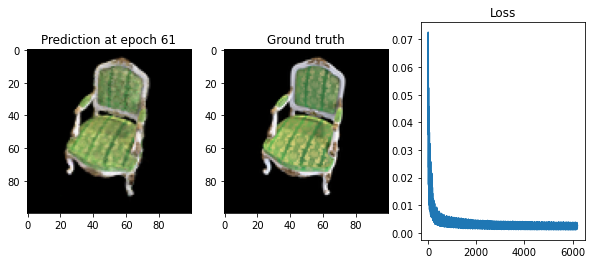

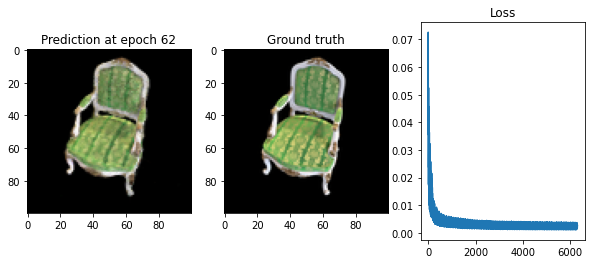

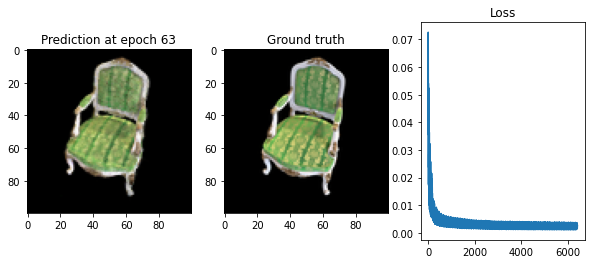

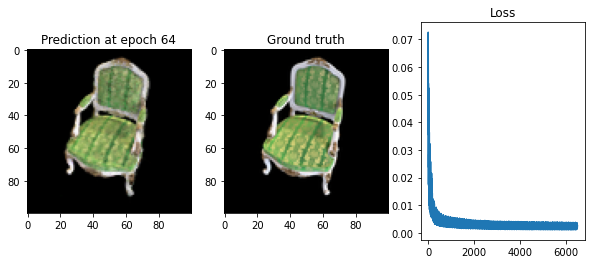

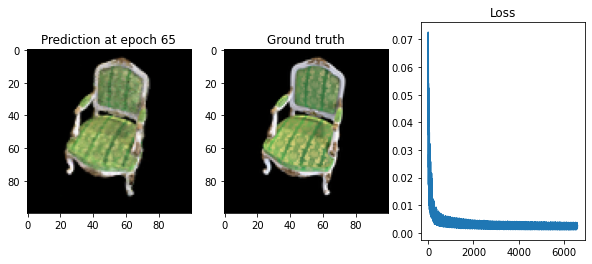

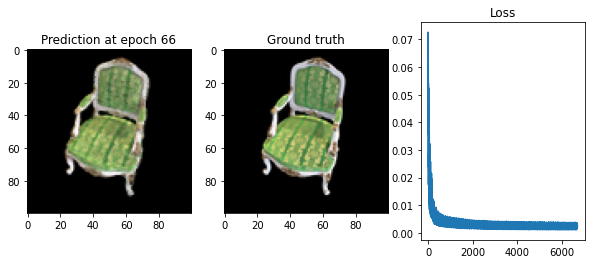

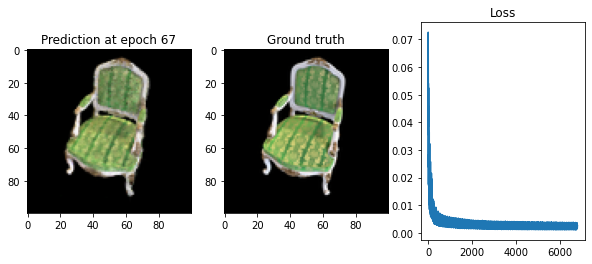

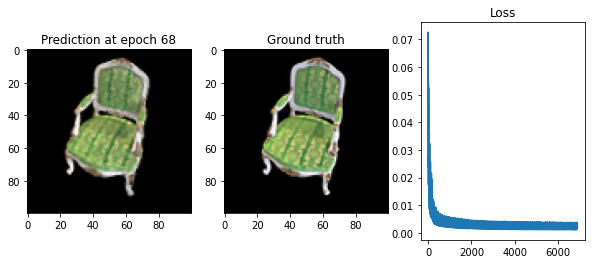

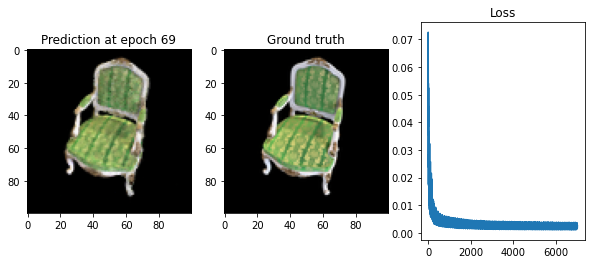

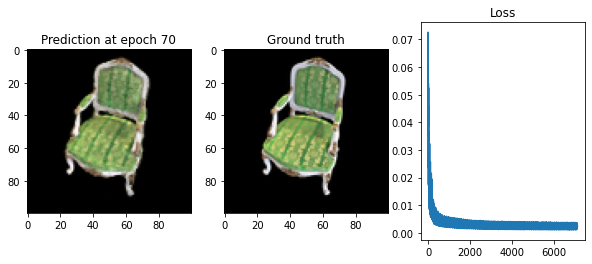

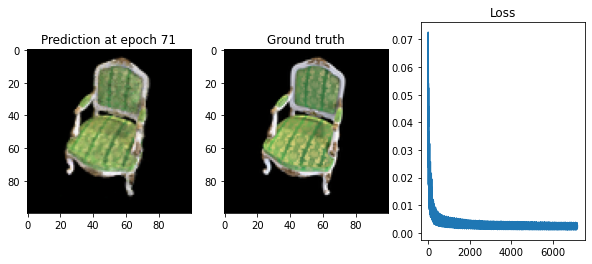

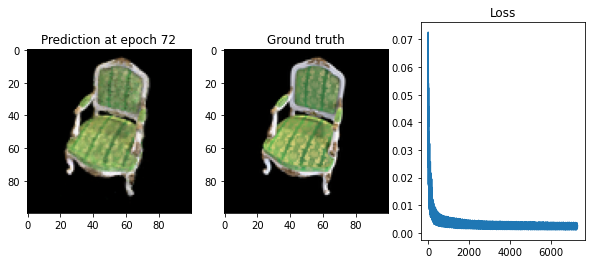

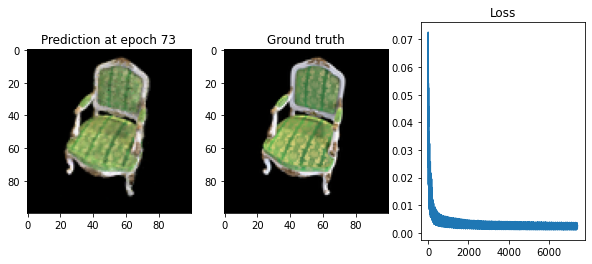

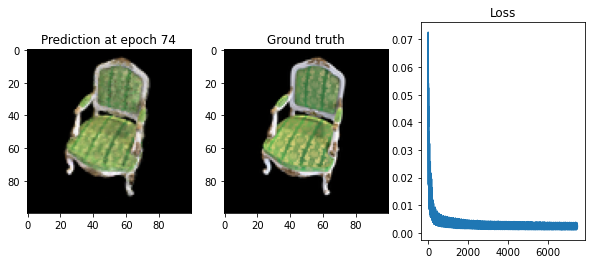

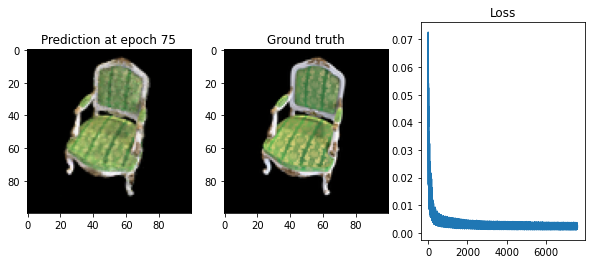

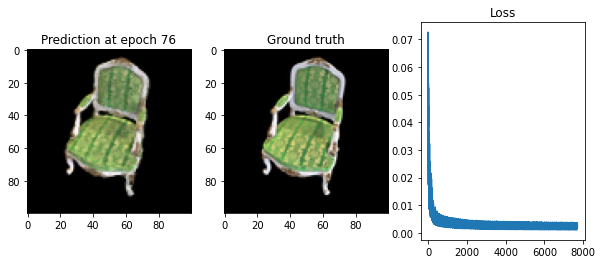

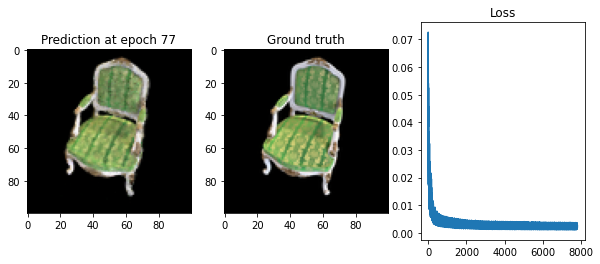

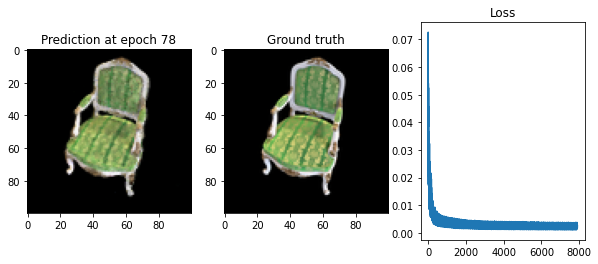

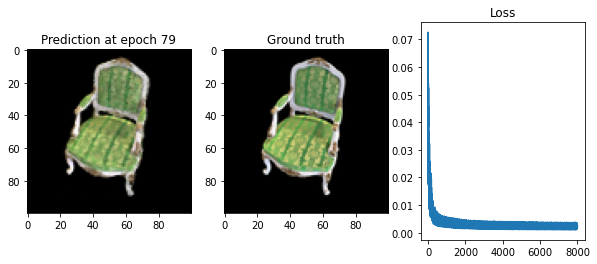

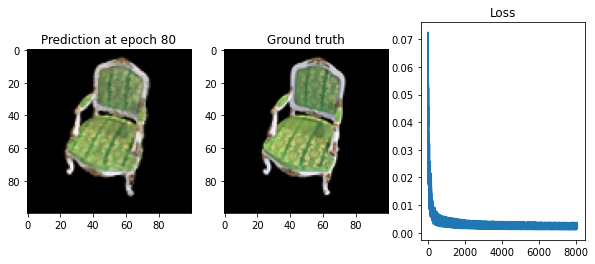

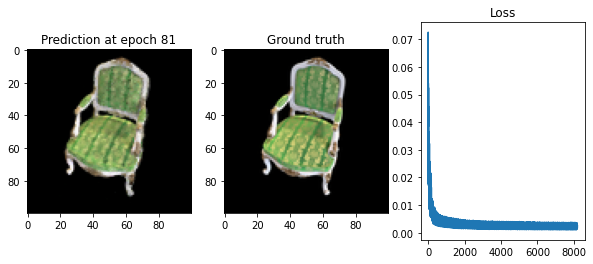

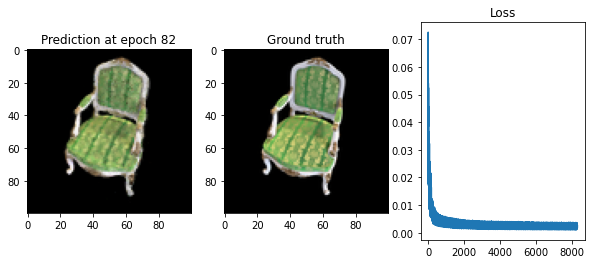

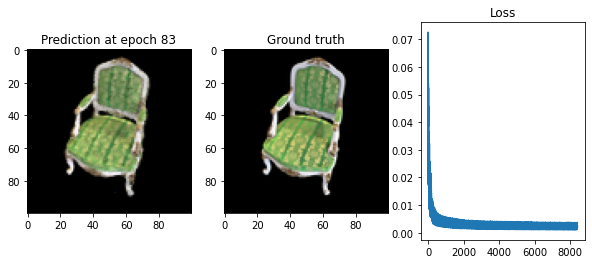

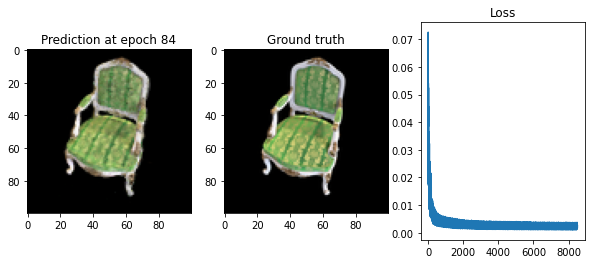

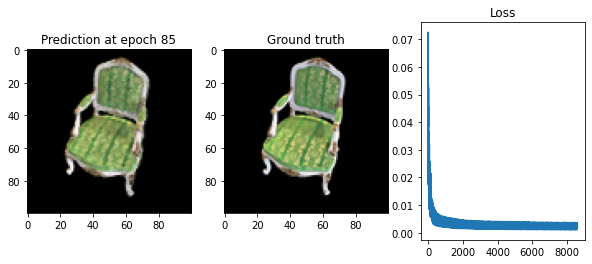

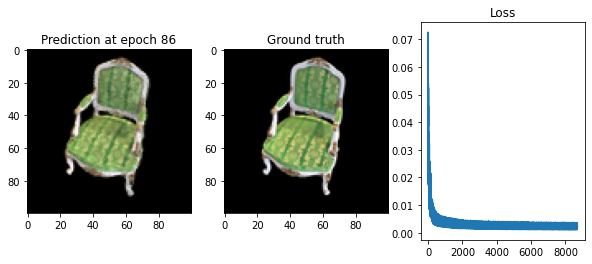

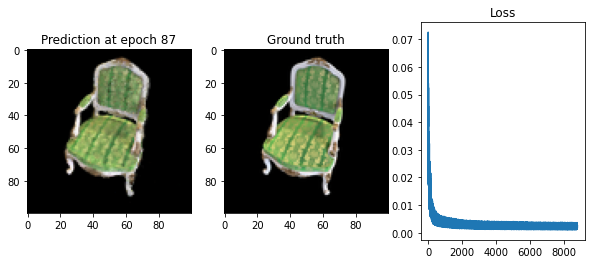

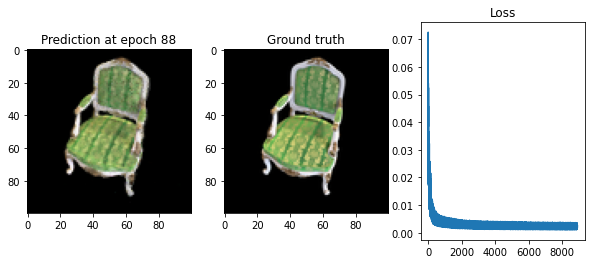

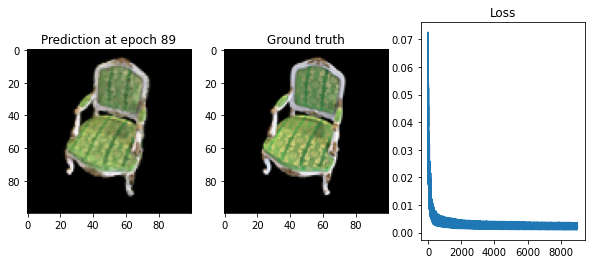

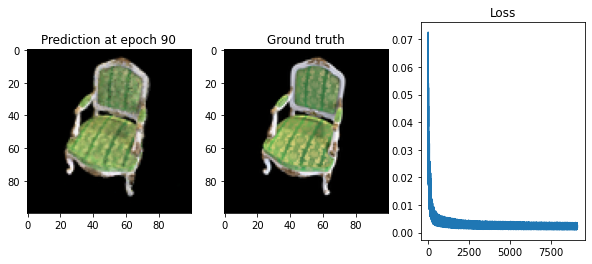

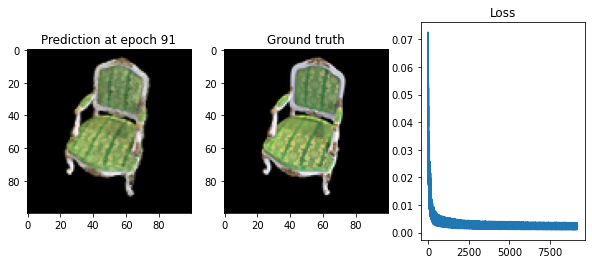

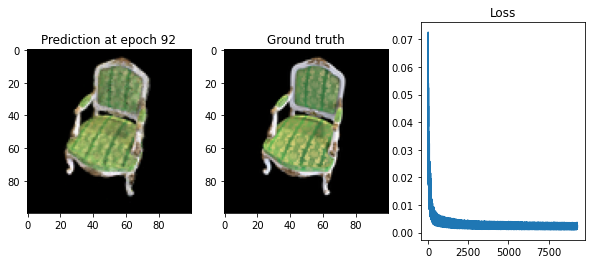

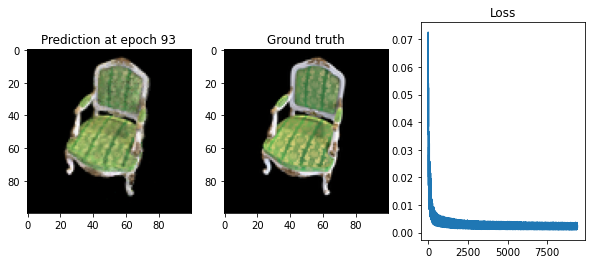

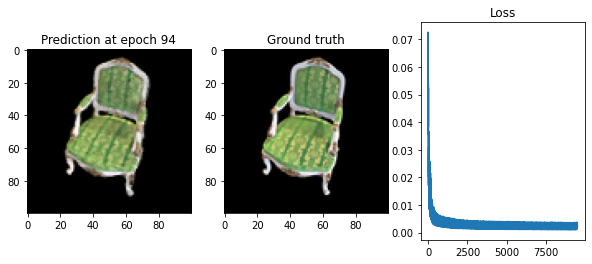

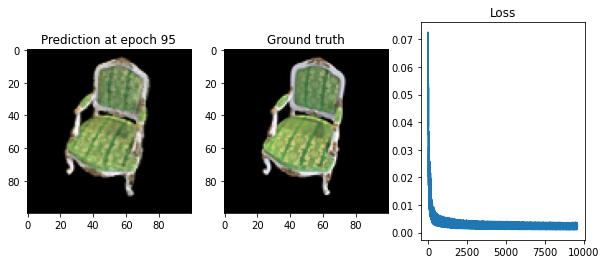

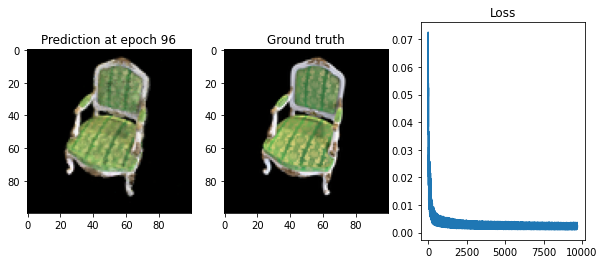

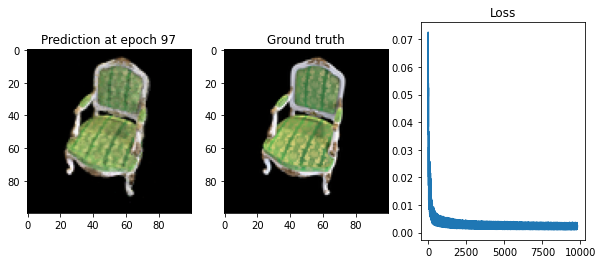

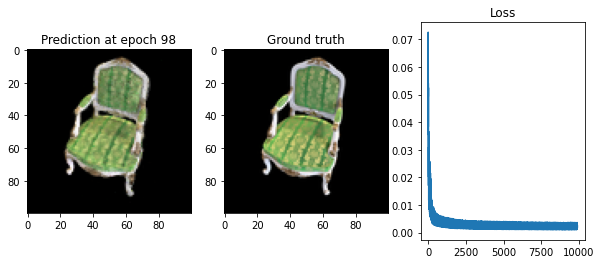

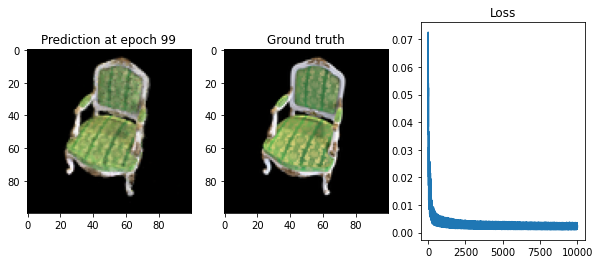

In [12]:
# ------------------------ PARAMETERS ------------------------
# Number of functions used in the positional encoding (Be sure to update the 
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: nerf.positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 228


# Optimizer parameters
lr = 5e-3
#num_iters = 100000
epochs = 100
display_every = 100  # Number of iters after which stats are displayed

# Define the model. We find that initializing NeRF with an already trained model speeds
# the training process for a enw scene!
model = nerf.TinyNerfModel().to(device)
model.load_state_dict(torch.load("/gdrive/My Drive/nerf_lego.pt"))
model.eval()
#model = nerf.TinyNerfModel(num_encoding_functions=num_encoding_functions)
#model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = []

near_thresh, far_thresh = get_thresholds(radius)
#near_thresh = 2.
#far_thresh = 6.

# ------------------------ TRAINING LOOP ------------------------


for epoch in range(epochs):
    for i, dat in enumerate(dataset):
        target_image, target_pose = dat
        target_image = torch.Tensor(target_image).to(device)
        target_pose = torch.Tensor(target_pose).to(device)
        rgb_predicted = nerf.run_one_iter_of_tinynerf(model, height, width, focal_length,
                                                 target_pose, near_thresh,
                                                 far_thresh, depth_samples_per_ray,
                                                 encode, nerf.get_minibatches)
        loss = torch.nn.functional.mse_loss(rgb_predicted, target_image)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        
    # Now we compare the prediction of NeRF at the test-pose vs. the round truth
    rgb_predicted = nerf.nerf_prediction(model, height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, nerf.get_minibatches)
    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Prediction at epoch {epoch}")
    plt.subplot(132)
    plt.imshow(testimg.detach().cpu().numpy())
    plt.title("Ground truth")
    plt.subplot(133)
    plt.plot(losses)
    plt.title("Loss")
    
    plt.show()



## Save / load the model

In [14]:
torch.save(model.state_dict(), "/gdrive/My Drive/nerf_chair.pt")
#torch.save(model.state_dict(), "/gdrive/My Drive/nerf_hotdog.pt")
#torch.save(model.state_dict(), "/gdrive/My Drive/nerf_hotdog.pt")

In [ ]:
#model = nerf.TinyNerfModel().to(device)
#model.load_state_dict(torch.load("/gdrive/My Drive/nerf_hotdog.pt"))
#model.eval()

#model = nerf.TinyNerfModel().to(device)
#model.load_state_dict(torch.load("/gdrive/My Drive/nerf_lego.pt"))
#model.eval()

model = nerf.TinyNerfModel().to(device)
model.load_state_dict(torch.load("/gdrive/My Drive/nerf_chair.pt"))
model.eval()

TinyNerfModel(
  (layer1): Linear(in_features=39, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (layer5): Linear(in_features=32, out_features=4, bias=True)
)

## Render novel views using a trained NeRF

### sample new views
* our radius (how far we are away we position the camera ) is sampled from $\mathcal{U}[r-1, r+1]$


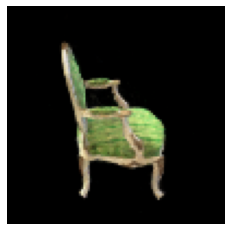

In [30]:
UP = torch.tensor([0.,0.,1.]).unsqueeze(dim=0).to(device)

def get_new_pose(center, radius):
    """
    generates a new pose / perspective for the NeRF model
    """

    rot = random_rotation().to(device)
    unit_x = torch.tensor([1.,0.,0.]).to(device)
    new_t = center + radius*(rot @ unit_x)

    new_t[2] = torch.abs(new_t[2])


    cam_rot = look_at_rotation(at=new_t.unsqueeze(dim=0), 
                               camera_position=center.unsqueeze(dim=0),up=UP) #tform_cam2world[0, :3, :3]#

    #cam_rot = torch.transpose(cam_rot, 1,2)
    transform = torch.zeros((4,4))#.to(device)
    
    transform[:3, :3] = cam_rot
    transform[:3, 3] = new_t
    transform[3, 3] = 1
    #print(look_at_rotation(center))
    return transform


depth_samples_per_ray = 240

r = torch.tensor(np.random.uniform(radius.item()-1, radius.item()+1)).to(device)
near_thresh, fat_thresh = get_thresholds(r)

new_pose = get_new_pose(center, r).to(device)
predicted = nerf.nerf_prediction(model, height, width, focal_length, new_pose,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encode, nerf.get_minibatches)

show(predicted.cpu())

## Render new dataset

To successfully train our generative model, we generate a temporary dataset $\hat{\mathcal{T}}$. 

In [ ]:
num_encoding_functions = 6
encode = lambda x: nerf.positional_encoding(x, num_encoding_functions=num_encoding_functions)
depth_samples_per_ray = 240


poses = []
images = []
n_images = 30000
n_dataset = 10000

path = "/gdrive/My Drive/temp_dataset_chair_new.pt"
dataset = AutoNeRF_Dataset()

for i in range(n_images):

    r = torch.tensor(np.random.uniform(radius.item()-1, radius.item()+1)).to(device)
    near_thresh, fat_thresh = get_thresholds(r)
    new_pose = get_new_pose(center, r).to(device)
    predicted = nerf.nerf_prediction(model, height, width, focal_length, new_pose,
                                near_thresh, far_thresh, depth_samples_per_ray,
                                encode, nerf.get_minibatches).cpu().detach().numpy()
    poses.append(new_pose.cpu().detach().numpy())
    images.append(predicted)
    

    del predicted
    del new_pose
    if i%1000==0:
        print("at iteration ", i)
        
    if (i+1) % n_dataset == 0 and i>0:
        
        # new now save the temporary dataset, since we have reached max capacity
        pth = os.path.splitext(path)
        filename = pth[-2] + str((i+1)//n_dataset)+ pth[-1]

        print("saving file with %s frames to %s" %(n_dataset, filename))
        poses_ = np.array(poses)
        images_ = np.array(images)

        dataset.pth = filename
        dataset.images = images_
        dataset.poses = poses_
        dataset.focal_length = np.array(focal_length.cpu().detach().numpy())
        dataset.save()
        # now we reset every variable and create a new dataset

        poses = []
        images = []
        dataset = AutoNeRF.data.AutoNeRF_Dataset()


at iteration  0
at iteration  1000
